# Setup

In [12]:
!pip install faiss-cpu

In [13]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /var/tmp/pip-req-build-dckiy1r1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /var/tmp/pip-req-build-dckiy1r1
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [14]:
import clip
import torch


device = "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)


## Config

In [15]:
num_dimensions = 512

In [16]:
vector_cache_filepath = "article_id_to_vector_map.pickle"

## Imports

In [17]:
import clip
import faiss
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
from tqdm import tqdm
import torch



## Ingest Data

In [18]:
df = pd.read_csv("data/h_and_m/articles.csv")

def _write_image_file_path_if_exists(row):
    article_id = str(row['article_id'])
    image_file_path = f"data/h_and_m/images/0{article_id[:2]}/0{article_id}.jpg"

    if not os.path.exists(image_file_path):
        return None
    return image_file_path

df["image_path"] = df.apply(_write_image_file_path_if_exists, axis=1)
df = df.dropna(subset=["image_path"])

In [19]:
df = df.sample(frac=1)

In [20]:

df

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,image_path
48526,692331001,692331,Julia jumpsuit J,265,Dress,Garment Full body,1010001,All over pattern,9,Black,...,D,Divided,2,Divided,53,Divided Collection,1013,Dresses Ladies,"Playsuit in soft, patterned jersey with a V-ne...",data/h_and_m/images/069/0692331001.jpg
26588,617470001,617470,Seal basic,89,Other shoe,Shoes,1010001,All over pattern,71,Light Blue,...,G,Baby Sizes 50-98,4,Baby/Children,42,Kids & Baby Shoes,1020,Shoes,Cotton canvas espadrilles with elastic gores i...,data/h_and_m/images/061/0617470001.jpg
38176,656719015,656719,Serpente HW slim trouser,272,Trousers,Garment Lower body,1010004,Check,9,Black,...,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Tailored trousers in a stretch weave with two ...,data/h_and_m/images/065/0656719015.jpg
85632,820505001,820505,Varbro linen dress,265,Dress,Garment Full body,1010016,Solid,73,Dark Blue,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,"Straight-style, knee-length dress in jersey ma...",data/h_and_m/images/082/0820505001.jpg
89385,837949001,837949,Flirty Flake eardeco,70,Earring,Accessories,1010016,Solid,10,White,...,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Metal earrings with a clip at the top and post...,data/h_and_m/images/083/0837949001.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13724,559619005,559619,Simple as That Top,298,Bikini top,Swimwear,1010016,Solid,10,White,...,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini top. Triangular cups with r...,data/h_and_m/images/055/0559619005.jpg
46956,687331006,687331,Aquarius hood,308,Hoodie,Garment Upper body,1010016,Solid,73,Dark Blue,...,D,Divided,2,Divided,53,Divided Collection,1005,Jersey Fancy,Oversized top in soft sweatshirt fabric with a...,data/h_and_m/images/068/0687331006.jpg
101944,900687001,900687,Velour set,270,Garment Set,Garment Full body,1010016,Solid,52,Pink,...,G,Baby Sizes 50-98,4,Baby/Children,44,Baby Essentials & Complements,1002,Jersey Basic,Set with a top and pair of trousers in soft ve...,data/h_and_m/images/090/0900687001.jpg
15421,566942002,566942,Bob solid,59,Swimwear bottom,Swimwear,1010016,Solid,9,Black,...,F,Menswear,3,Menswear,26,Men Underwear,1018,Swimwear,Knee-length swim shorts in woven fabric with a...,data/h_and_m/images/056/0566942002.jpg


## Helper Methods

In [21]:
def _get_512features_from_text(
    text: str,
):
    tokens = clip.tokenize(text).to(device)
    with torch.no_grad():
        return model.encode_text(tokens).cpu().numpy()[0]


def _get_512features_from_image(
    pil_image: str,
):
    preprocessed_image = preprocess(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        return model.encode_image(preprocessed_image).cpu().numpy()[0]


def _read_pil_image_from_url(
    url: str,
):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def _get_512features_from_image_url(url):
    pil_image = _read_pil_image_from_url(url)
    return _get_512features_from_image(pil_image=pil_image)


In [22]:
def _write_vector_cache(
    article_id_to_vector_map,
):
    with open(vector_cache_filepath, "wb") as file_handler:
        # source, destination
        pickle.dump(article_id_to_vector_map, file_handler)                   
    

In [23]:
def _read_vector_cache():
    if os.path.exists(vector_cache_filepath):    
        with open(vector_cache_filepath, "rb") as file_handler:
            return pickle.load(file_handler)
    else:
        return {}

## Generate Vectors

In [24]:
article_id_to_vector_map = _read_vector_cache()

vector_index = len(article_id_to_vector_map)
print(vector_index)

remaining_df = df[~df["article_id"].isin(article_id_to_vector_map.keys())]

for _, row in tqdm(remaining_df.iterrows(), total=remaining_df.shape[0]):
    if vector_index % 500:
        _write_vector_cache(
            article_id_to_vector_map=article_id_to_vector_map,
        )        
    
    article_id = row["article_id"]
    
    # Generate caption Vector
    
    caption = str(row["detail_desc"])
    caption += f" Its color is {row['graphical_appearance_name'].lower()} {row['colour_group_name'].lower()}."
    caption += f" Its category is {row['section_name'].lower()} {row['index_group_name'].lower()}."
    caption += f" Its type is {row['product_type_name'].lower()} {row['prod_name'].lower()} {row['product_group_name'].lower()}."    

    caption_vector = _get_512features_from_text(
        text=caption[:77],
    )    
    
    # Generate image vector
    
    pil_image = Image.open(row["image_path"])
        
    image_vector = _get_512features_from_image(
        pil_image=pil_image,
    )    
    
    # Cache composite vector
    mean_vector = np.mean( np.array([ image_vector, caption_vector ]), axis=0 )

    article_id_to_vector_map[article_id] = mean_vector
    
    vector_index += 1

## Create Vector Database

In [25]:
vector_database = faiss.IndexFlatL2(num_dimensions) 

vector_index_to_article_id_map = {}


num_vectors = len(article_id_to_vector_map)

vectors = []

for vector_index, (article_id, vector) in tqdm(enumerate(article_id_to_vector_map.items())):
    vector_index_to_article_id_map[vector_index] = article_id
    vectors.append(vector)
    
vector_database.add(np.array(vectors))

77477it [00:00, 1567237.97it/s]


## Search Vector Database

In [26]:
def make_grid(
    images,
    size=256,
):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

def get_product_image(
    query,
    number_of_user_options,
):
    query_vector = _get_512features_from_text(
        text=query,
    )

    distances, results = vector_database.search(
        np.array([query_vector]),
        number_of_user_options,
    )
    
    images = []

    for result_vector_index in results[0]:
        article_id = vector_index_to_article_id_map[result_vector_index]

        result_df_row = df[df["article_id"] == article_id].iloc[0]
        image = Image.open(result_df_row["image_path"])
        images.append(image)
    
    images = make_grid(images=images)
    display(images)
        


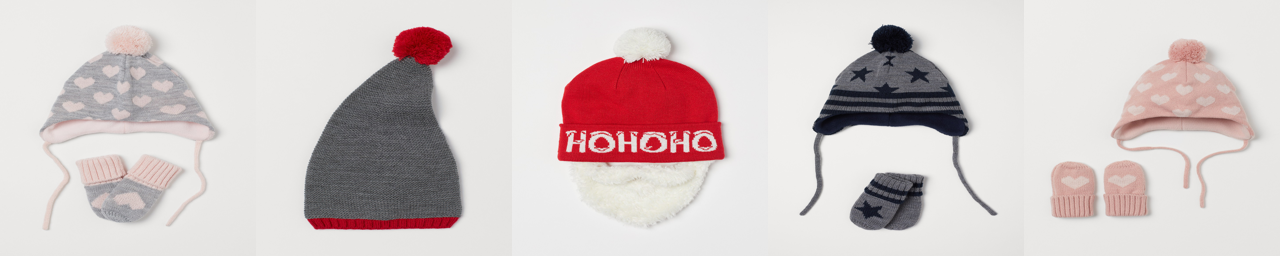

In [27]:
get_product_image(
    query="santa's hat",
    number_of_user_options=5,
)